# Training the Model

This notebook builds a classification model to predict the outcome of football matches using engineered features from historical team performance data. The model is trained using XGBoost, a gradient boosting algorithm that handles NaN values natively. The goal is to classify match results as home win, away win, or draw based on team strength, form, and other match statistics.

### Imports

In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier,DMatrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

match_data = pd.read_csv("../data/training_data.csv")

match_data=match_data.drop(columns=['DATE'],axis=1)

print(match_data.dtypes)
print(match_data.columns.tolist())
match_data.head()

HOME_TEAM                          object
HOME_STRENGTH                     float64
HOME_LEAGUE_STRENGTH              float64
HOME_GOALS_FOR_LAST3              float64
HOME_GOALS_AGAINST_LAST3          float64
HOME_TARGET_LAST3                 float64
HOME_FOULS_LAST3                  float64
HOME_CORNERS_LAST3                float64
HOME_YELLOW_LAST3                 float64
HOME_RED_LAST3                    float64
HOME_OPP_STRENGTH_LAST3           float64
HOME_OPP_LEAGUE_STRENGTH_LAST3    float64
HOME_FORM_LAST3                   float64
AWAY_TEAM                          object
AWAY_STRENGTH                     float64
AWAY_LEAGUE_STRENGTH              float64
AWAY_GOALS_FOR_LAST3              float64
AWAY_GOALS_AGAINST_LAST3          float64
AWAY_TARGET_LAST3                 float64
AWAY_FOULS_LAST3                  float64
AWAY_CORNERS_LAST3                float64
AWAY_YELLOW_LAST3                 float64
AWAY_RED_LAST3                    float64
AWAY_OPP_STRENGTH_LAST3           

,HOME_TEAM,HOME_STRENGTH,HOME_LEAGUE_STRENGTH,HOME_GOALS_FOR_LAST3,HOME_GOALS_AGAINST_LAST3,HOME_TARGET_LAST3,HOME_FOULS_LAST3,HOME_CORNERS_LAST3,HOME_YELLOW_LAST3,HOME_RED_LAST3,...,AWAY_OPP_STRENGTH_LAST3,AWAY_OPP_LEAGUE_STRENGTH_LAST3,AWAY_FORM_LAST3,RESULT,STRENGTH_DIFF,LEAGUE_STRENGTH_DIFF,FORM_DIFF,HOME_GOAL_DIFF_LAST3,AWAY_GOAL_DIFF_LAST3,TOTAL_GOALS
0,AFC Ajax,84.3,76.2,3.000000,0.666667,NaN,NaN,NaN,NaN,NaN,...,83.566667,80.4,3.0,H,-4.5,-2.4,0.0,2.333333,2.000000,6.0
1,AFC Ajax,84.3,76.2,2.666667,1.666667,NaN,NaN,NaN,NaN,NaN,...,74.066667,78.6,3.0,A,-4.7,-2.4,0.0,1.000000,1.333333,1.0
2,AVS,75.7,78.6,1.333333,2.000000,3.000000,12.000000,2.666667,3.0,0.333333,...,79.466667,78.6,4.0,H,-2.6,0.0,0.0,-0.666667,0.000000,1.0
3,AVS,75.7,78.6,0.666667,1.666667,1.666667,11.333333,2.333333,3.0,0.000000,...,79.466667,78.6,7.0,D,-0.4,0.0,0.0,-1.000000,-1.333333,0.0
4,AVS,75.7,78.6,0.333333,1.333333,1.000000,12.666667,4.666667,3.0,0.000000,...,80.966667,78.6,1.0,A,-8.5,0.0,0.0,-1.000000,2.666667,5.0


### Set Target and Categorical Features

In [21]:
# Define target and features
target_col = "RESULT"

X = match_data.drop(columns=[target_col,"TOTAL_GOALS","HOME_TEAM","AWAY_TEAM"])
y = match_data[target_col]

X.columns.tolist()

['HOME_STRENGTH',
 'HOME_LEAGUE_STRENGTH',
 'HOME_GOALS_FOR_LAST3',
 'HOME_GOALS_AGAINST_LAST3',
 'HOME_TARGET_LAST3',
 'HOME_FOULS_LAST3',
 'HOME_CORNERS_LAST3',
 'HOME_YELLOW_LAST3',
 'HOME_RED_LAST3',
 'HOME_OPP_STRENGTH_LAST3',
 'HOME_OPP_LEAGUE_STRENGTH_LAST3',
 'HOME_FORM_LAST3',
 'AWAY_STRENGTH',
 'AWAY_LEAGUE_STRENGTH',
 'AWAY_GOALS_FOR_LAST3',
 'AWAY_GOALS_AGAINST_LAST3',
 'AWAY_TARGET_LAST3',
 'AWAY_FOULS_LAST3',
 'AWAY_CORNERS_LAST3',
 'AWAY_YELLOW_LAST3',
 'AWAY_RED_LAST3',
 'AWAY_OPP_STRENGTH_LAST3',
 'AWAY_OPP_LEAGUE_STRENGTH_LAST3',
 'AWAY_FORM_LAST3',
 'STRENGTH_DIFF',
 'LEAGUE_STRENGTH_DIFF',
 'FORM_DIFF',
 'HOME_GOAL_DIFF_LAST3',
 'AWAY_GOAL_DIFF_LAST3']

### Training Testing Split

In [22]:
# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Then use this in train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42
)

# Now DMatrix will work fine (if you still need it for advanced use)
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

### Train Model

In [23]:

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',  # for multiclass classification
    eval_metric='mlogloss',      # closest to CatBoost's 'MultiClass'
    verbosity=1,
    random_state=42,
    use_label_encoder=False      # disables deprecated label encoding
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

[0]	validation_0-mlogloss:1.09066


C:\Users\kushl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:29:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-mlogloss:0.99895
[200]	validation_0-mlogloss:1.00055
[300]	validation_0-mlogloss:1.00621
[400]	validation_0-mlogloss:1.01301
[499]	validation_0-mlogloss:1.01784
Accuracy: 0.5047


### Feature Selection

As we can see, that the Accuracy is around 50% which is the same as random guess. So now we should try to possibly reduce the number of features that may be resulting in the model getting confused.

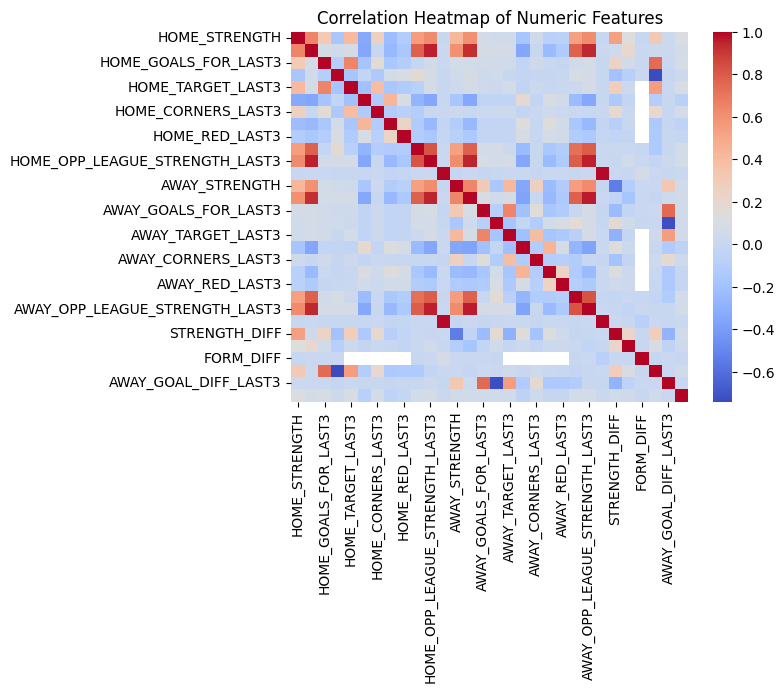

                           Feature  Importance
24                   STRENGTH_DIFF    0.134916
13            AWAY_LEAGUE_STRENGTH    0.043754
25            LEAGUE_STRENGTH_DIFF    0.036098
1             HOME_LEAGUE_STRENGTH    0.035034
0                    HOME_STRENGTH    0.034437
12                   AWAY_STRENGTH    0.033589
27            HOME_GOAL_DIFF_LAST3    0.033468
21         AWAY_OPP_STRENGTH_LAST3    0.033174
22  AWAY_OPP_LEAGUE_STRENGTH_LAST3    0.032918
2             HOME_GOALS_FOR_LAST3    0.031891
9          HOME_OPP_STRENGTH_LAST3    0.031667
14            AWAY_GOALS_FOR_LAST3    0.031609
28            AWAY_GOAL_DIFF_LAST3    0.031520
15        AWAY_GOALS_AGAINST_LAST3    0.031495
23                 AWAY_FORM_LAST3    0.031469
18              AWAY_CORNERS_LAST3    0.031378
4                HOME_TARGET_LAST3    0.031330
6               HOME_CORNERS_LAST3    0.029883
11                 HOME_FORM_LAST3    0.029768
19               AWAY_YELLOW_LAST3    0.029645
8            

In [24]:
numeric_data = match_data.select_dtypes(include=["number"])
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

# Get feature importance as a pandas DataFrame
importances = model.feature_importances_
feature_names = X.columns if hasattr(X, "columns") else [f"f{i}" for i in range(X.shape[1])]
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(importance_df)



### Train a New Model, With Subset of Features

I am also going to change the target, as two-level classification is easier than three-level. So the outcomes will now be Away Win or No Away Win

In [25]:
drop_cols = [
    "HOME_YELLOW_LAST3",
    "HOME_CORNERS_LAST3",
    "AWAY_CORNERS_LAST3",
    "AWAY_YELLOW_LAST3",
    "HOME_FOULS_LAST3",
    "AWAY_FOULS_LAST3",
    "AWAY_RED_LAST3",
    "HOME_RED_LAST3",
    "FORM_DIFF",

]

# Create binary label: 1 if away team wins, 0 otherwise
match_data['AWAY_WIN'] = match_data['RESULT'].apply(lambda x: 1 if x == 'A' else 0)

# Feature matrix (drop unneeded columns)
X = match_data.drop(columns=drop_cols + ["HOME_TEAM", "AWAY_TEAM", "AWAY_WIN", "TOTAL_GOALS", "RESULT"])

# Target
y = match_data["AWAY_WIN"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize and train model
model = XGBClassifier(
    n_estimators=500,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False,
    verbosity=1
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Evaluate
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[0]	validation_0-logloss:0.58749
[100]	validation_0-logloss:0.59585


C:\Users\kushl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:32:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[200]	validation_0-logloss:0.62943
[300]	validation_0-logloss:0.66755
[400]	validation_0-logloss:0.70460
[499]	validation_0-logloss:0.74041
Test Accuracy: 0.7032898820608318
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      1126
           1       0.51      0.31      0.38       485

    accuracy                           0.70      1611
   macro avg       0.63      0.59      0.59      1611
weighted avg       0.68      0.70      0.68      1611



### Tune the Parameters of the Model

Now that we have achieved a higher accuracy by trying out different parameters to which achieves the highest accuracy

In [ ]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'reg_lambda': [1, 3, 5, 7, 9],           
    'subsample': [0.6, 0.8, 1.0],            
    'colsample_bytree': [0.6, 0.8, 1.0],     
    'gamma': [0, 1, 5],                      
    'max_bin': [32, 64, 128]                 
}

# Initialize XGBoost classifier
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

# Perform randomized search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Show best parameters
print("Best Parameters:")
print(random_search.best_params_)

# Best cross-validation score
print("\nBest Cross-Validation Accuracy:")
print(random_search.best_score_)

# Use best estimator for final prediction
result_classifier = random_search.best_estimator_
y_pred = result_classifier.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importance
importances = result_classifier.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters:
{'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 10, 'max_bin': 128, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}

Best Cross-Validation Accuracy:
0.7291853936946553

Test Accuracy: 0.7268777157045313
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      1126
           1       0.65      0.20      0.31       485

    accuracy                           0.73      1611
   macro avg       0.69      0.58      0.57      1611
weighted avg       0.71      0.73      0.67      1611

                           Feature  Importance
16                   STRENGTH_DIFF    0.180643
8                    AWAY_STRENGTH    0.080892
0                    HOME_STRENGTH    0.065108
18            HOME_GOAL_DIFF_LAST3    0.047104
1             HOME_LEAGUE_STRENGTH    0.043834
4                HOME_TARGET_LAST3    0.042982
12               AWAY_TARGET_

## Number of Expected Goals Classifier

Since we already have a classifier to predict the outcome of each match, we can now make a different model to try and predict the number of expected goals for the upcoming matches. We will use the XGBoost Classifier again for this, the target for this model will be the `TOTAL_GOALS` column which we will convert into an `OVER_3_5` column. We will be predicting whether there will be over or under 3.5 goals in the match.

In [28]:
# Create binary target for over 3.5 goals
match_data['OVER_3_5'] = match_data['TOTAL_GOALS'].apply(lambda x: 1 if x > 3.5 else 0)

# Drop unnecessary columns
drop_cols = [
    "RESULT", "HOME_TEAM", "AWAY_TEAM", "TOTAL_GOALS", "FORM_DIFF", 
    "HOME_YELLOW_LAST3", "AWAY_YELLOW_LAST3", "HOME_RED_LAST3", "AWAY_RED_LAST3",
    "AWAY_FOULS_LAST3", "HOME_FOULS_LAST3", "AWAY_WIN", "OVER_3_5"  # regression target
]

# Prepare features and target
X = match_data.drop(columns=drop_cols)
y = match_data["OVER_3_5"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Initialize and train XGBoost model
goals_classifier = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    eval_metric='logloss',  # for binary classification
    use_label_encoder=False,
    random_state=42,
    verbosity=1
)

goals_classifier.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Predict and evaluate
y_pred = goals_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature importances
importances = goals_classifier.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

[0]	validation_0-logloss:0.60370
[100]	validation_0-logloss:0.59721


C:\Users\kushl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [19:35:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[200]	validation_0-logloss:0.59963
[300]	validation_0-logloss:0.60258
[400]	validation_0-logloss:0.60663
[499]	validation_0-logloss:0.61347
Accuracy: 0.7157045313469894
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      1140
           1       0.60      0.08      0.15       471

    accuracy                           0.72      1611
   macro avg       0.66      0.53      0.49      1611
weighted avg       0.69      0.72      0.63      1611

                           Feature  Importance
10            AWAY_LEAGUE_STRENGTH    0.072074
16  AWAY_OPP_LEAGUE_STRENGTH_LAST3    0.058189
0                    HOME_STRENGTH    0.051329
18                   STRENGTH_DIFF    0.049286
1             HOME_LEAGUE_STRENGTH    0.048495
7   HOME_OPP_LEAGUE_STRENGTH_LAST3    0.047293
3         HOME_GOALS_AGAINST_LAST3    0.045420
19            LEAGUE_STRENGTH_DIFF    0.045235
9                    AWAY_STRENGTH    0.044103
15         AWAY_OPP_STRENGTH_LAST3

As we see from the output, we are able to successfully predict whether the amount of goals in a game are more or less than 3.5 goals with about 72% accuracy. While this accuracy may not seem very high, football is very unpredictable, and being able just to get this level of accuracy is impressive.

### Save Models for Tournament Predictions

In [29]:
result_classifier.save_model("xgboost_result_model.json")
goals_classifier.save_model("xgboost_goals_model.json")